<a href="https://colab.research.google.com/github/SheKJana/first-own-repository/blob/main/Nach_KAQs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Semesteraufgabe BINA- nach KAQs gegliedert**

# Umgebung vorbereiten

In [59]:
#Vorbereitung Blibliotheken und Visualisierungstools hochalde
!pip install scikit-learn
!pip install kaggle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Markdown


# Daten hochladen

In [83]:
#NHANES (aus Kaggel Quelle) hochladen und zusammenführen
# NHANES (aus Kaggle-Quelle) hochladen und zusammenführen

import pandas as pd

# 1. CSV-Dateien laden
diet = pd.read_csv("https://raw.githubusercontent.com/iceangel79/MScWinf_Gruppenarbeit_Sem2/refs/heads/main/Semesterarbeit/Datasets/Kaggle/diet.csv")
examination = pd.read_csv("https://raw.githubusercontent.com/iceangel79/MScWinf_Gruppenarbeit_Sem2/refs/heads/main/Semesterarbeit/Datasets/Kaggle/examination.csv")
questionnaire = pd.read_csv("https://raw.githubusercontent.com/iceangel79/MScWinf_Gruppenarbeit_Sem2/refs/heads/main/Semesterarbeit/Datasets/Kaggle/questionnaire.csv")
demographic = pd.read_csv("https://raw.githubusercontent.com/iceangel79/MScWinf_Gruppenarbeit_Sem2/refs/heads/main/Semesterarbeit/Datasets/Kaggle/demographic.csv")

# --- 2. Relevante Spalten definieren ---

# Ernährung (Nährstoffaufnahme, nur vorhandene und relevante Spalten)
diet_cols = [
    'SEQN',             # ID
    'DR1TKCAL',         # Kalorien
    'DR1TTFAT',         # Gesamtfett
    'DR1TSFAT',         # gesättigte Fette
    'DR1TMFAT',         # einfach ungesättigte Fette
    'DR1TPFAT',         # mehrfach ungesättigte Fette
    'DR1TMAGN',         # Magnesium
    'DR1TSODI'          # Natrium
]

# Untersuchung (z. B. BMI, Blutdruck)
examination_cols = [
    'SEQN',
    'BMXBMI',   # BMI
    'BPXSY1',   # systolischer Blutdruck
    'BPXDI1'    # diastolischer Blutdruck
]

# Fragebogen (Krankheiten, Konsum, Verhalten)
questionnaire_cols = [
    'SEQN', 'DIQ010', 'BPQ020', 'BPQ030', 'BPQ050A', 'BPQ080', 'BPQ090D',
    'MCQ080', 'MCQ220',
    'PAD615', 'DID040', 'DIQ160', 'DIQ170',
    'WHD010', 'WHD020',
    'DED120', 'DED125',
    'MCQ086',
    'HIQ011', 'HUQ010',
    'SMD460', 'SMAQUEX2', 'SMDANY', 'SMQ710', 'SMQ621',
    'IND235', 'INDFMMPC',
    'CBQ596', 'CBQ611',
    'DBD910', 'CBD070',
    'ALQ110', 'ALQ120Q', 'ALQ151',
    'FSD032C', 'FSD151'
]

# Demografische Angaben
demographic_cols = [
    'SEQN',
    'RIDAGEYR',    # Alter
    'RIAGENDR',    # Geschlecht
    'INDHHIN2',    # Haushaltseinkommen (kategorisch)
    'INDFMPIR',    # Armutsverhältnis (kontinuierlich)
    'DMDEDUC2',    # Bildungsniveau
    'DMDMARTL'     # Familienstand
]

# 3. Auswahl der Spalten aus den CSVs
diet_small = diet[[col for col in diet_cols if col in diet.columns]]
examination_small = examination[[col for col in examination_cols if col in examination.columns]]
questionnaire_small = questionnaire[[col for col in questionnaire_cols if col in questionnaire.columns]]
demographic_small = demographic[[col for col in demographic_cols if col in demographic.columns]]

# 4. Merge auf SEQN
df = diet_small.merge(examination_small, on="SEQN", how="left")
df = df.merge(questionnaire_small, on="SEQN", how="left")
df = df.merge(demographic_small, on="SEQN", how="left")


# Datenbereinigung + Engineering

In [89]:
# Klassifizierung der Variablen in Must-have und semi must-have

# Absolut erforderliche Spalten (müssen vollständig vorhanden sein)
absolut_pflicht = ['RIDAGEYR', 'RIAGENDR']

# Relativ erforderliche Spalten (mind. 2 von 4 müssen vorhanden sein)
relativ_pflicht = ['DR1TKCAL', 'DR1TTFAT', 'DR1TSODI', 'DR1TPROT']

# Sicherheitscheck: Nur relativ Pflichtspalten verwenden, die im DataFrame vorhanden sind
relativ_pflicht = [spalte for spalte in relativ_pflicht if spalte in df.columns]

# Markiere Datensätze mit fehlenden absoluten Pflichtfeldern
fehlende_absolut = df[absolut_pflicht].isna().any(axis=1)

# Zähle pro Zeile, wie viele der relativen Nährstoffwerte vorhanden sind
anzahl_vorhanden = df[relativ_pflicht].notna().sum(axis=1)

# Bedingung: mindestens 2 der 4 relativen Werte müssen vorhanden sein
gueltige_relativ = anzahl_vorhanden >= 2

# Filter anwenden: nur behalten, wenn beide Bedingungen erfüllt
df_bereinigt = df[~fehlende_absolut & gueltige_relativ].copy()

# Statistik: Wie viele der 4 relativen Felder hatte jeder Datensatz
df_bereinigt['anzahl_von_4_naehrwerten_vorhanden'] = anzahl_vorhanden

# Ausgabe
print(f"Anzahl gültiger Datensätze nach den Kriterien: {len(df_bereinigt)}")


Anzahl gültiger Datensätze nach den Kriterien: 8531


# Alte Bereinigung basierend auf 8 zwingend Variabeln

# Neuste Bereinigung auf zwei absoluten Variablen und 4 relativen:
Aufgrund des grossen Datenverlust haben wir uns entscheiden die nur **zwei Variablen als absolut zwingend zu klassifizieren. Alter + Geschlecht.** Denn ohne dies ist Berechnung der Differenz von empfohlenere Tageszufuhr und effektiver gar nicht möglich, da wir den Bedarf nicht eruieren könnne.

Bei **4 weiteren müssen mindesten 2 von 4 vorhanden** sein.
Kalorien

- Kalorien
- Natrium
- Fett
- Kohlenhydrate

Dadurch reduzieren wir unsere Datensatz statt um 40% um nur ca. 13%.

In [100]:
#Absolute und bedingte Pflichvariablen definieren
# --- Absolut zwingend ---
absolute_must_have = ['RIDAGEYR', 'RIAGENDR']

# --- Relativ zwingend: mindestens 2 von 5 müssen vorhanden sein ---
relative_fields = ['DR1TKCAL', 'DR1TSODI', 'DR1TSUGR', 'DR1TTFAT', 'DR1TPROT']

# Prüfe: Sind alle absolut zwingenden Werte vorhanden?
absolut_ok = df[absolute_must_have].notna().all(axis=1)

# Prüfe: Wie viele der relativen Felder sind pro Zeile vorhanden?
anzahl_relative_vorhanden = df[relativ_pflicht].notna().sum(axis=1)

# Mindestens 2 von 5 vorhanden → gültig
relativ_ok = anzahl_relative_vorhanden >= 2

# Kombination beider Bedingungen
gueltige_zeilen = absolut_ok & relativ_ok

# Gefilterter Datensatz
df_bereinigt = df[gueltige_zeilen].copy()

# Optional: Anzahl herausgefilterter Zeilen
print(f"Behaltene Datensätze: {df_bereinigt.shape[0]} von {df.shape[0]}")
print(f"Ausgeschlossene Datensätze: {df.shape[0] - df_bereinigt.shape[0]}")


Behaltene Datensätze: 8531 von 9813
Ausgeschlossene Datensätze: 1282


# Feature Engeneering

NHANES Datensatz

Engineering um fehlende BMI Wert aufzufüllen

In [94]:
#Feature Engeneering BMI: Fehlende BMI-Wert bei den 758 Datensätzen durch Körpergewicht und Körpergrösse berechnen

# Voraussetzung:
# - WHD010: Körpergröße in cm
# - WHD020: Körpergewicht in kg
# - BMXBMI: BMI (wenn vorhanden)

# Formel: BMI = Gewicht (kg) / (Größe in m)^2
def berechne_bmi(row):
    if pd.isna(row['BMXBMI']) and not pd.isna(row['WHD010']) and not pd.isna(row['WHD020']):
        groesse_m = row['WHD010'] / 100
        return row['WHD020'] / (groesse_m ** 2)
    return row['BMXBMI']

# Zähle vorher, wie viele BMI-Werte fehlen
missing_bmi_before = df['BMXBMI'].isna().sum()

# Wende die Berechnung an
df['BMXBMI'] = df.apply(berechne_bmi, axis=1)

# Zähle nachher, wie viele noch fehlen
missing_bmi_after = df['BMXBMI'].isna().sum()
recovered = missing_bmi_before - missing_bmi_after

print(f"BMI-Werte ergänzt: {recovered} von {missing_bmi_before} fehlenden Fällen")


BMI-Werte ergänzt: 79 von 758 fehlenden Fällen


Engineering Gesundheitszustand: Übergewicht, Bluthochdruck, Diabetes oder gesund

<Figure size 800x500 with 0 Axes>

<ipython-input-95-dd798a525020>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Text(47.4, 0, '46.4%')

Text(28.9, 1, '27.9%')

Text(19.1, 2, '18.1%')

Text(8.5, 3, '7.5%')

Text(0.5, 1.0, 'Verteilung Gesundheitsstatus (in %)')

Text(0.5, 0, 'Anteil in Prozent')

Text(0, 0.5, 'Gesundheitsstatus')

(0.0, 56.4)

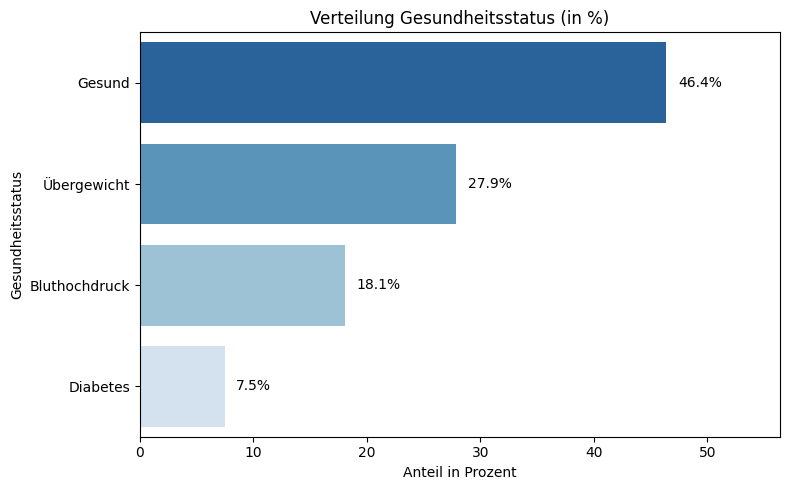

In [95]:
#Feature erstellen für Krankheiten - Übergewicht; Bluthochdruck und Diabetes
#es werden nur solche als gesund klassifiziert welche weder übergewichtig sind, oder an Bluthochdruck oder Diabetes leiden.
def classify_health(row):
    if row['DIQ010'] == 1:
        return 'Diabetes'
    elif row['BPXSY1'] >= 130 or row['BPXDI1'] >= 80:
        return 'Bluthochdruck'
    elif row['BMXBMI'] >= 25:
        return 'Übergewicht'
    else:
        return 'Gesund'

# Wichtig: Arbeite mit dem bereinigten DataFrame, nicht df_clean
df_bereinigt.loc[:, 'Gesundheitsstatus'] = df_bereinigt.apply(classify_health, axis=1)

# Optional: Export
df_bereinigt.to_csv("NHANES_bereinigt.csv", index=False)

# Zähle Gesundheitsstatus
status_counts = df_bereinigt['Gesundheitsstatus'].value_counts()

#Visualisierung der Verteilung der "Krankheiten" auf usnere Sample
#Berechnung % Wert
status_counts = df_bereinigt['Gesundheitsstatus'].value_counts()
status_percent = (status_counts / status_counts.sum() * 100).round(1)

# Plot erstellen
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    y=status_percent.index,
    x=status_percent.values,
    orient='h',
    palette='Blues_r'
)

# Prozentwerte auf die Balken schreiben
for i, (label, value) in enumerate(status_percent.items()):
    ax.text(value + 1, i, f"{value:.1f}%", va='center')

plt.title("Verteilung Gesundheitsstatus (in %)")
plt.xlabel("Anteil in Prozent")
plt.ylabel("Gesundheitsstatus")
plt.xlim(0, max(status_percent.values) + 10)  # etwas Puffer rechts
plt.tight_layout()

Engineering Klassifizieren von Raucher/nicht Rauchern

<Figure size 800x500 with 0 Axes>

Text(6527, 0, '6522')

Text(1457, 1, '1452')

Text(1128, 2, '1123')

Text(989, 3, '984')

Text(99, 4, '94')

Text(0.5, 1.0, 'Rauchverhalten (absolut) – Total: 10175 Personen')

Text(0.5, 0, 'Anzahl Personen')

Text(0, 0.5, 'Rauchverhalten')

(0.0, 6572.0)

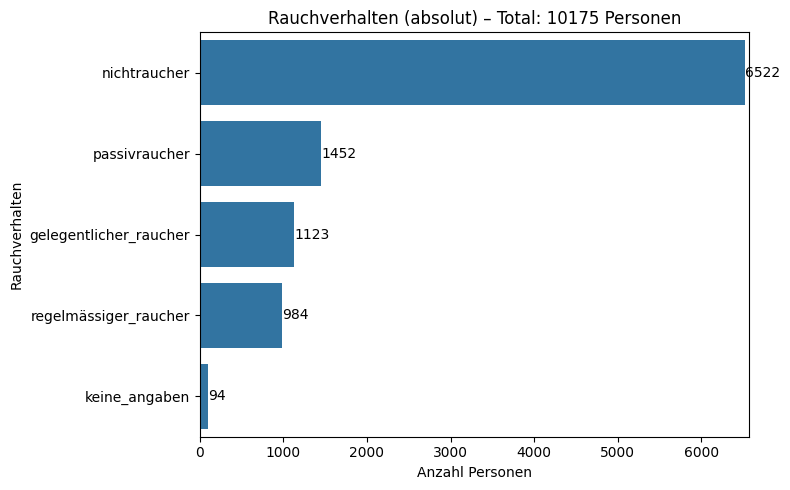

In [96]:
#Feature engeenering für Klassifikation von: "" nicht raucher, passiv Raucher, gelegenheits Raucher, regelmässiger Raucher"
#falls ein Person selbst raucht wird die Tatsache, dass sie/er allfällig in einem Haushalt lebt wo andere Personen ebenfalls rauchen vernachlässigt. Da dies gesundheitlich nicht mehr eine grosse Relevanz hat

def klassifiziere_raucher(row):
    smq621 = row.get("SMQ621")
    smq710 = row.get("SMQ710")
    smd460 = row.get("SMD460")

    if pd.isna(smq621) and pd.isna(smq710) and pd.isna(smd460):
        return "keine_angaben"

    if not pd.isna(smq710) and smq710 >= 3:
        return "regelmässiger_raucher"
    elif not pd.isna(smq710) and 1 <= smq710 <= 2:
        return "gelegentlicher_raucher"
    elif not pd.isna(smq621) and smq621 >= 100:
        return "regelmässiger_raucher"
    elif not pd.isna(smq621) and 1 <= smq621 < 100:
        return "gelegentlicher_raucher"
    elif not pd.isna(smd460) and smd460 >= 1:
        return "passivraucher"
    else:
        return "nichtraucher"

def klassifiziere_alkohol(row):
    alq110 = row.get("ALQ110")
    alq120q = row.get("ALQ120Q")

    if pd.isna(alq110) and pd.isna(alq120q):
        return "keine_angaben"

    if alq110 == 2:
        return "konsumiert_keinen_alkohol"

    if not pd.isna(alq120q):
        if alq120q == 0:
            return "konsumiert_keinen_alkohol"
        elif 1 <= alq120q <= 3:
            return "gelegentlich"
        elif 4 <= alq120q <= 6:
            return "regelmässig"
        elif alq120q >= 7:
            return "regelmässig_und_viel"

    return "keine_angaben"

# Neue Spalten erstellen
questionnaire["rauchverhalten_kategorie"] = questionnaire.apply(klassifiziere_raucher, axis=1)
questionnaire["alkoholkonsum_kategorie"] = questionnaire.apply(klassifiziere_alkohol, axis=1)

# Zähle die Kategorien
rauch_counts_abs = questionnaire["rauchverhalten_kategorie"].value_counts()
gesamt_anzahl_rauch = rauch_counts_abs.sum()

# Plot erstellen
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    y=rauch_counts_abs.index,
    x=rauch_counts_abs.values,
    orient="h",
    color="#1f77b4"  # Gleiche Farbe wie für Krankheiten
)

# Zahlen in Balken einfügen
for i, (label, value) in enumerate(rauch_counts_abs.items()):
    ax.text(value + 5, i, f"{value}", va="center", fontsize=10)

# Titel und Achsen
plt.title(f"Rauchverhalten (absolut) – Total: {gesamt_anzahl_rauch} Personen")
plt.xlabel("Anzahl Personen")
plt.ylabel("Rauchverhalten")
plt.xlim(0, max(rauch_counts_abs.values) + 50)
plt.tight_layout()
plt.show()


Engineering von Klassifizierungen im Bezug auf Alkoholkonsum

<Figure size 800x500 with 0 Axes>

<ipython-input-97-43942d96fed1>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Text(7031, 0, '7030')

Text(858, 1, '857')

Text(418, 2, '417')

Text(156, 3, '155')

Text(73, 4, '72')

Text(0.5, 1.0, 'Alkoholkonsum-Kategorie (absolut) – Total: 8531 Personen')

Text(0.5, 0, 'Anzahl Personen')

Text(0, 0.5, 'Konsumverhalten')

(0.0, 7050.0)

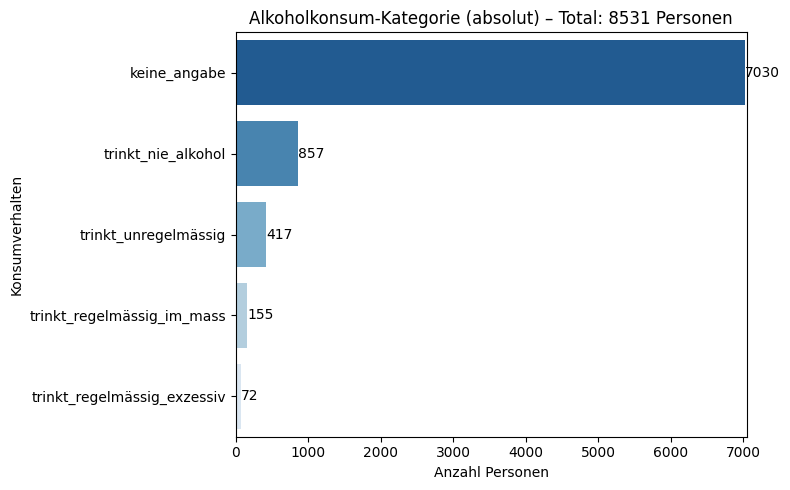

In [97]:
# Ziel: Personen systematisch in vier Gruppen einteilen basierend auf:
# - ob sie jemals Alkohol konsumiert haben (ALQ110)
# - wie häufig sie im letzten Jahr getrunken haben (ALQ120Q)
# - ob sie jemals eine Phase mit exzessivem Konsum hatten (ALQ151)
#
# Kategorien:
# - 'trinkt_nie_alkohol':      noch nie ≥12 Drinks im Leben (ALQ110 = 2)
# - 'trinkt_unregelmässig':    ALQ110 = 1, aber ALQ120Q ≤ 1x/Monat oder fehlt
# - 'trinkt_regelmässig_im_mass': ALQ110 = 1, ALQ120Q = 1–4x/Woche, keine Exzesse (ALQ151 ≠ 1)
# - 'trinkt_regelmässig_exzessiv': ALQ110 = 1, und ALQ151 = 1 oder ALQ120Q ≥ 5x/Woche

def klassifiziere_alkohol(row):
    if row['ALQ110'] == 2:
        return 'trinkt_nie_alkohol'
    elif row['ALQ110'] == 1:
        if pd.isna(row['ALQ120Q']):
            return 'trinkt_unregelmässig'  # keine Frequenzangabe trotz grundsätzlich Konsum
        elif row['ALQ120Q'] <= 1:
            return 'trinkt_unregelmässig'
        elif row['ALQ151'] == 1 or row['ALQ120Q'] >= 5:
            return 'trinkt_regelmässig_exzessiv'
        else:
            return 'trinkt_regelmässig_im_mass'
    return 'keine_angabe'

# Wende Klassifikation an
df_bereinigt['alkoholkonsum_kategorie'] = df_bereinigt.apply(klassifiziere_alkohol, axis=1)

# Berechne absolute Anzahl pro Kategorie
alkohol_counts_abs = df_bereinigt['alkoholkonsum_kategorie'].value_counts()
gesamt_anzahl = alkohol_counts_abs.sum()  # Gesamtzahl der klassifizierten Fälle

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    y=alkohol_counts_abs.index,
    x=alkohol_counts_abs.values,
    orient='h',
    palette='Blues_r'
)

# Zahlen auf Balken schreiben
for i, (label, value) in enumerate(alkohol_counts_abs.items()):
    ax.text(value + 1, i, f"{value}", va='center')

# Titel und Achsen
plt.title(f"Alkoholkonsum-Kategorie (absolut) – Total: {gesamt_anzahl} Personen")
plt.xlabel("Anzahl Personen")
plt.ylabel("Konsumverhalten")
plt.xlim(0, max(alkohol_counts_abs.values) + 20)
plt.tight_layout()
plt.show()

Kombination von Rauch- und Trinkverhalten

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='alkoholkonsum_kategorie', ylabel='rauchverhalten_kategorie'>

Text(0.5, 1.0, 'Kombination von Rauch- und Alkoholkonsum')

Text(0.5, 36.58159722222221, 'Alkoholkonsum-Kategorie')

Text(95.5815972222222, 0.5, 'Rauchverhalten-Kategorie')

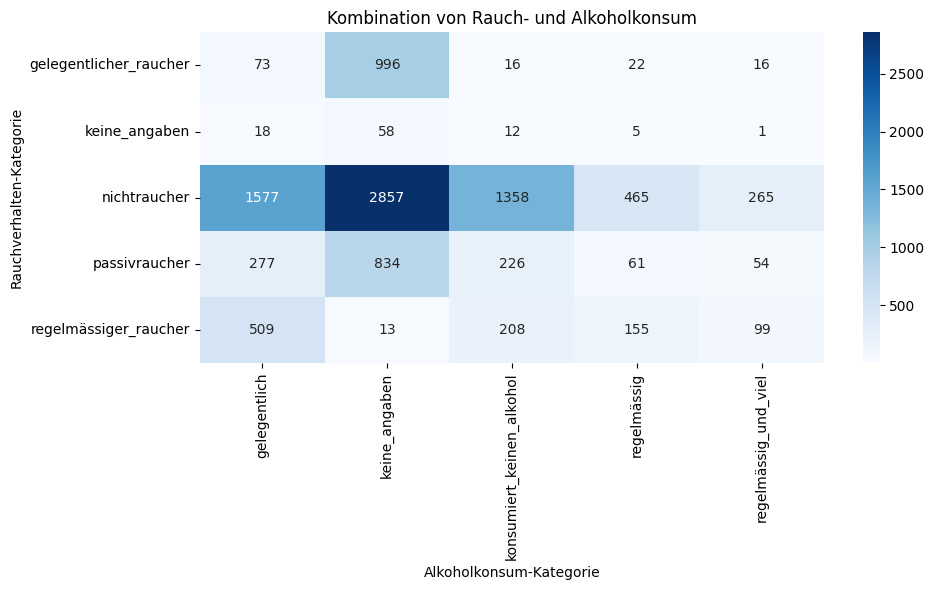

In [98]:
# Kreuztabelle erstellen
kreuz = pd.crosstab(
    questionnaire['rauchverhalten_kategorie'],
    questionnaire['alkoholkonsum_kategorie']
)

# Heatmap darstellen
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(kreuz, annot=True, fmt="d", cmap="Blues")
plt.title("Kombination von Rauch- und Alkoholkonsum")
plt.xlabel("Alkoholkonsum-Kategorie")
plt.ylabel("Rauchverhalten-Kategorie")
plt.tight_layout()
plt.show()


# KAQ 1: In welchen Ernährungsgewohnheiten liegt eine potenziell unausgewogene Nährstoffzufuhr vor?